# Harmonizing starMAP dataset and the Smart-seq4 dataset

# Table of Contents
1. [Creating and training the model](#section1)
2. [Training the baseline methods](#section2)
3. [Benchmarking on integration and imputation metrics](#section3)
4. [Obtaining a common meaningful representation and visualizing it](#section4)
5. [Classifying STARmap cells using their latent representation](#section5)
6. [Finding spatially DE genes](#section6)

## Introduction
We present here scVI_fish, a model based on the scVI model whose aim is to provide various tools to analyse single cell RNA data. scVI_fish's goal is to be able to jointly analyse a scRNA seq dataset and a dataset created using the FISH protocol. FISH datasets provide the spatial coordinates of each cell inside the tissue and measurements with higher sentivity nevertheless a lower number of genes are measured than in scRNA seq experiments.
In this particular notebook we will be presenting a complete joint analysis of the mouse cortex SMARTseq4 dataset with the mouse Visual cortex STARmap dataset. We display the results of the benchmarking of our method against Liger, Seurat and the original model scVI.

## Getting a common meaningful representation
Here, we'd like two things. 
First, the two datasets should mix pretty well (if the common representation captures biologically relevant information). This is measured by the Entropy of Batch Mixing which quantifies the homogeneity of set of samples whete two populations are present. 

Second, we want to make sure that cells from the two datasets are not mixed in our method's inferred latent space to the detriment of the biological information intrisic to each dataset. We want each cell's proximity with other cells from the same dataset to be retained in the joint analysis. To assess that we look at the Jaccard Index on the sets of nearest same dataset neighbors of each cell before and after our model's joint analysis.

We also plot the latent representation of the cells according to their cell types, hoping that cells from different datasets but same cell types lie close to each other in our latent space.

## Imputation
We train our model and the baselines without observing some fish genes . We then try to reconstruct the unobserved values for each cell, and compare them with the real ones. 
For the baselines we use a k-NN approach, and for our model we directly output the expected counts.
We compute, for each of those unobserved genes, the absolute and relative errors as well as the spearman correlation with the measured values.

We compare the spatial maps of the tissues colored by one gene's expression level using either the measured values or one of the method's imputed values to see if the analyses retain the spatial patterns displayed by some genes.

Moreover we can also plot the a spatial map of the tissue colored by the expression level of a gene that was sequenced only in the scRNA seq experiment to see if we can discover spatially differentially expressed genes.

In [1]:
import os
os.chdir('../..')
os.getcwd()

'/home/ec2-user/scVI'

In [2]:
import json
with open('docs/notebooks/SMARTseq_and_STARmap.config.json') as f:
    config = json.load(f)
print(config)

n_epochs_all = config['n_epochs'] if 'n_epochs' in config else None
save_path = config['save_path'] if 'save_path' in config else 'data/'
n_samples_tsne = config['n_samples_tsne'] if 'n_samples_tsne' in config else None
n_samples_posterior_density = config['n_samples_posterior_density'] if 'n_samples_posterior_density' in config else None
train_size = config['train_size'] if 'train_size' in config else None
M_sampling = config['M_sampling'] if 'M_sampling' in config else None
M_permutation = config['M_permutation'] if 'M_permutation' in config else None
rate = config['rate'] if 'rate' in config else None

{'save_path': 'data/'}


In [3]:
import numpy as np
from sklearn.decomposition import PCA, NMF
from scvi.dataset import DropseqDataset, StarmapDataset, GeneExpressionDataset, SmfishDataset, Smartseq4Dataset
from scvi.inference import TrainerFish, UnsupervisedTrainer
from scvi.models import VAEF, VAE
from scvi.inference.posterior import plot_imputation, proximity_imputation, entropy_batch_mixing
from scvi.inference.annotation import compute_accuracy_nn
from MNNs import MNN
from LIGER import *
from seurat import *
from scipy.stats import spearmanr, gaussian_kde
from sklearn.manifold import TSNE
import umap
import torch
import pysal
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


<a id='section1'></a>

# 1. Creating and training the model

In [4]:
file='starmap1000.loom'

In [5]:
gene_dataset_seq = Smartseq4Dataset(save_path=save_path)
gene_dataset_fish = StarmapDataset(save_path=save_path, file=file, scrna_seq_genes=gene_dataset_seq.gene_names)

# adding an offset to fish batches which are not shared with the scRNA seq datasets
gene_dataset_fish.batch_indices = gene_dataset_fish.batch_indices + gene_dataset_seq.n_batches

Preprocessing dataset
Finished preprocessing dataset
Preprocessing dataset
Finished preprocessing dataset


In [6]:
import csv
gene_lengths = {}
reader = csv.reader(open('data/gene_len.txt', 'r'), delimiter=' ')
for row in reader:
    if row[0].lower() in gene_dataset_seq.gene_names:
        gene_lengths[row[0].lower()] = float(row[1])

#keeping only genes whose length we have                     
genes_fish = np.intersect1d(list(gene_lengths.keys()), gene_dataset_fish.gene_names)
gene_dataset_fish.filter_genes(genes_fish)
genes_seq = np.array(list(gene_lengths.keys()))
gene_dataset_seq.filter_genes(genes_seq)
gene_dataset_seq.put_genes_first(genes_fish)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Downsampling from 996 to 956 genes
Downsampling from 2522 to 2522 cells
Downsampling from 7250 to 6776 genes
Downsampling from 14249 to 14249 cells


In [7]:
# OPTIONAL: keeping only fish genes for integration benchmark
gene_dataset_seq.filter_genes(genes_fish)

Downsampling from 6776 to 956 genes
Downsampling from 14249 to 14249 cells


In [8]:
list_lengths = np.array([float(gene_lengths[gene]) for gene in gene_dataset_seq.gene_names])
gene_dataset_seq.X = np.multiply(gene_dataset_seq.X, 
                             np.mean(list_lengths)/list_lengths).astype(gene_dataset_fish.X.dtype)

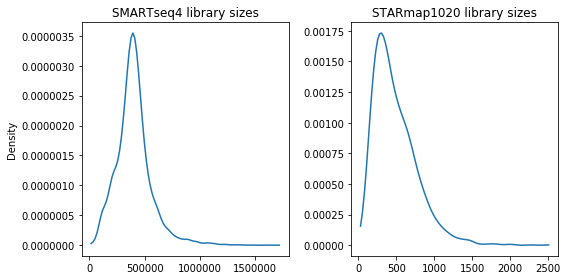

In [9]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
data = np.sum(gene_dataset_seq.X, axis=1)
kde = gaussian_kde(data)
# these are the values over wich your kernel will be evaluated
dist_space = np.linspace(min(data), max(data), 100)
plt.plot(dist_space, kde(dist_space))
plt.ylabel('Density')
plt.title('SMARTseq4 library sizes')

plt.subplot(122)
data = np.sum(gene_dataset_fish.X, axis=1)
kde = gaussian_kde(data)
# these are the values over wich your kernel will be evaluated
dist_space = np.linspace(min(data), max(data), 100)
plt.plot(dist_space, kde(dist_space))
plt.title('STARmap1020 library sizes')
plt.tight_layout()

Choosing the fish genes whose expression values we are going to hide from the model in all cells during the training in order to test our imputation mehod of non observed genes

In [10]:
idx_genes_discarded = np.random.choice(np.arange(956), 150, replace=False)
indexes_to_keep = np.delete(np.arange(len(genes_fish)), idx_genes_discarded)

In [11]:
# remove bogus cells when we will filter more genes (Liger, Seurat and scVI)
to_keep = np.where(np.sum(gene_dataset_fish.X[:, indexes_to_keep], axis=1) > 0)[0]
gene_dataset_fish.update_cells(to_keep)
gene_dataset_fish.x_coord = gene_dataset_fish.x_coord[to_keep]
gene_dataset_fish.y_coord = gene_dataset_fish.y_coord[to_keep]
to_keep = np.where(np.sum(gene_dataset_seq.X[:, indexes_to_keep], axis=1) > 0)[0]
gene_dataset_seq.update_cells(to_keep)

Downsampling from 2522 to 2522 cells
Downsampling from 14249 to 14249 cells


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


## Running scVI_fish

In [12]:
n_batch = gene_dataset_fish.n_batches + gene_dataset_seq.n_batches

n_epochs = 100 if n_epochs_all is None else n_epochs_all
vae = VAEF(gene_dataset_seq.nb_genes, indexes_to_keep, n_layers_decoder=2, n_latent=10,
           n_layers_shared=3, n_hidden=256, reconstruction_loss='zinb', reconstruction_loss_fish='nb', 
           dropout_rate=0.3, dispersion='gene-batch',n_batch=n_batch, model_library_seq=True, 
           model_library_fish=False)
trainer = TrainerFish(vae, gene_dataset_seq, gene_dataset_fish, train_size=0.75, verbose=False, frequency=1, 
                      n_epochs_even=1, n_epochs_kl=1000,
                                cl_ratio = 0, n_epochs_cl=150, scale=50)
trainer.train(n_epochs=n_epochs, lr=0.001)

training: 100%|██████████| 100/100 [12:16<00:00,  7.37s/it]


<a id='section2'></a>

# 2. Training the baseline methods

In [13]:
methods_list = ['scVI_fish', 'scVI', 'Liger', 'Seurat_v2']

## Running the Seurat v2 model

In [14]:
def run_seurat():
    seurat = SEURAT('starmap_harmonization')
    dataset_fish = StarmapDataset(save_path=save_path, file=file)
    dataset_fish.filter_genes(genes_fish[indexes_to_keep])
    seurat.create_seurat(dataset_fish, 1)
    seurat.create_seurat(gene_dataset_seq, 2)
    latent, _, _, _ = seurat.get_cca()
    latent_seurat_fish = latent[:gene_dataset_fish.X.shape[0], :]
    latent_seurat_seq = latent[gene_dataset_fish.X.shape[0]:, :]
    return latent_seurat_fish, latent_seurat_seq

## Running the Liger model

In [15]:
def run_liger():
    liger = LIGER()
    dataset_fish = StarmapDataset(save_path=save_path, file=file, scrna_seq_genes=gene_dataset_seq.gene_names)
    dataset_fish.filter_genes(genes_fish[indexes_to_keep])
    liger.create_liger(dataset_fish, gene_dataset_seq, 'Starmap', 'Smartseq')
    clusters_liger, latent_liger, cells_idx_fish, cells_idx_seq = liger.run_factorization(k=20)
    
    latent_liger_fish = latent_liger[:gene_dataset_fish.X.shape[0], :]
    latent_liger_seq = latent_liger[gene_dataset_fish.X.shape[0]:, :]
    # liger cluster labels start from one
    labels_liger_fish = clusters_liger[:gene_dataset_fish.X.shape[0]] - 1
    labels_liger_seq = clusters_liger[gene_dataset_fish.X.shape[0]:] - 1
    
    return latent_liger_fish, latent_liger_seq, labels_liger_fish, labels_liger_seq, cells_idx_seq, \
cells_idx_fish

## Using the scVI model as a baseline

scVI is also designed to do batch effect corrections on datasets that contain multiple batches. We are going to use it as a baseline that we compare to this new model that has been created by modifying scVI to address specifically this harmonization problem.

In [16]:
def run_scvi():
    
    gene_dataset = GeneExpressionDataset.concat_datasets(*(gene_dataset_fish, gene_dataset_seq), 
                                                         shared_batches=True)
    gene_dataset.filter_genes(genes_fish[indexes_to_keep])
    vae = VAE(gene_dataset.nb_genes, n_batch=n_batch, n_latent=10, dispersion="gene-batch", n_layers=2, 
              n_hidden=256)
    trainer_scvi = UnsupervisedTrainer(vae, gene_dataset, train_size=0.75, frequency=1)
    trainer_scvi.train(n_epochs=100, lr=0.001)
    dic = trainer_scvi.get_all_latent_and_imputed_values()
    latent_scvi = dic['latent']
    latent_scvi_fish = latent_scvi[:gene_dataset_fish.X.shape[0]]
    latent_scvi_seq = latent_scvi[gene_dataset_fish.X.shape[0]:]

    return latent_scvi_seq, latent_scvi_fish

# Here the trainer does not have access to the information provided by gene expression levels of scRNA-seq cells
# for genes that weren't measured in the starMAP experiment

In [17]:
def get_latents_and_labels(methods):
    latent_seq_dic = {}
    latent_fish_dic = {}
    labels_seq, labels_fish = {}, {}
    cells_idx_seq, cells_idx_fish = None, None
    for method_name in methods:
        if method_name == 'scVI_fish':
            dic_model_seq = trainer.get_all_latent_and_expected_frequencies(mode='scRNA')
            latent_seq = dic_model_seq["latent"]
            dic_model_fish = trainer.get_all_latent_and_expected_frequencies(mode='smFISH')
            latent_fish = dic_model_fish["latent"]
            
            latent_seq_dic[method_name] = latent_seq
            latent_fish_dic[method_name] = latent_fish
        elif method_name == 'scVI':
            latent_scvi_seq, latent_scvi_fish = run_scvi()
            latent_seq_dic[method_name] = latent_scvi_seq
            latent_fish_dic[method_name] = latent_scvi_fish
        elif method_name == 'Liger':
            latent_liger_fish, latent_liger_seq, labels_liger_fish, labels_liger_seq, cells_idx_seq, \
cells_idx_fish = run_liger()
            latent_seq_dic[method_name] = latent_liger_seq
            latent_fish_dic[method_name] = latent_liger_fish
            labels_seq[method_name] = labels_liger_seq
            labels_fish[method_name] = labels_liger_fish
        elif method_name == 'Seurat_v2':
            latent_seurat_fish, latent_seurat_seq = run_seurat()
            latent_seq_dic[method_name] = latent_seurat_seq
            latent_fish_dic[method_name] = latent_seurat_fish 
        else:
            print('Unknown method name: %s' % method_name)
    return latent_seq_dic, latent_fish_dic, labels_seq, labels_fish, cells_idx_seq, cells_idx_fish 

In [18]:
dic_latent_seq, dic_latent_fish, labels_seq_dic, labels_fish_dic, liger_cells_seq, liger_cells_fish = \
get_latents_and_labels(methods_list)

Keeping 956 genes
Downsampling from 956 to 806 genes
Downsampling from 16771 to 16771 cells
training: 100%|██████████| 100/100 [04:58<00:00,  2.99s/it]
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 956 to 806 genes
Downsampling from 2522 to 2522 cells
20
  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            


  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |====================================                                  |  51%
  |                                                                            
  |====================================                                  |  52%
  |                                                                            
  |=====================================                                 |  53%
  |                                                                            
  |======================================                                |  54%
  |                                                                            
  |======================================================================| 100%

Converged in
 
240.9556
 
seconds,
 
54

  |                                                                            
  |=========                                                             |  13%
  |                                                                            
  |==========                                                            |  14%
  |                                                                            
  |==========                                                            |  15%
  |                                                                            
  |===========                                                           |  16%
  |                                                                            
  |============                                                          |  17%
  |                                                                            
  |=============                                                         |  18%
  |                                     

   |++++++++++++++++++++++++++++++++++                | 68% ~06s          
   |+++++++++++++++++++++++++++++++++++               | 69% ~06s          
   |+++++++++++++++++++++++++++++++++++               | 70% ~06s          
   |++++++++++++++++++++++++++++++++++++              | 71% ~06s          
   |++++++++++++++++++++++++++++++++++++              | 72% ~06s          
   |+++++++++++++++++++++++++++++++++++++             | 73% ~06s          
   |+++++++++++++++++++++++++++++++++++++             | 74% ~05s          
   |++++++++++++++++++++++++++++++++++++++            | 75% ~05s          
   |+++++++++++++++++++++++++++++++++++++++           | 76% ~05s          
   |+++++++++++++++++++++++++++++++++++++++           | 77% ~05s          
   |++++++++++++++++++++++++++++++++++++++++          | 78% ~04s          
   |++++++++++++++++++++++++++++++++++++++++          | 79% ~04s          
   |+++++++++++++++++++++++++++++++++++++++++         | 80% ~04s          
   |+++++++++++++++++++++

   |+++++++++++++++++++++++++++++++++++++++++         | 81% ~01s          
   |++++++++++++++++++++++++++++++++++++++++++        | 82% ~01s          
   |++++++++++++++++++++++++++++++++++++++++++        | 83% ~01s          
   |+++++++++++++++++++++++++++++++++++++++++++       | 84% ~01s          
   |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~01s          
   |++++++++++++++++++++++++++++++++++++++++++++      | 86% ~01s          
   |++++++++++++++++++++++++++++++++++++++++++++      | 88% ~01s          
   |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~00s          
   |+++++++++++++++++++++++++++++++++++++++++++++     | 90% ~00s          
   |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~00s          
   |++++++++++++++++++++++++++++++++++++++++++++++    | 92% ~00s          
   |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~00s          
   |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~00s          
   |+++++++++++++++++++++

   |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~01s          
   |++++++++++++++++++++++++++++++++++++++++++++++++  | 96% ~01s          
   |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~01s          
   |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~00s          
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~00s          
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 18s


   |                                                  | 0 % ~calculating  
   |+                                                 | 1 % ~04s          
   |++                                                | 2 % ~04s          
   |++                                                | 3 % ~04s          
   |+++                                               | 4 % ~04s          
   |+++                                               | 5 % ~04s          
   |++++                                              | 6 % ~04s          
   |++++               

   |++++                                              | 7 % ~16s          
   |+++++                                             | 8 % ~16s          
   |+++++                                             | 9 % ~15s          
   |++++++                                            | 10% ~15s          
   |++++++                                            | 11% ~15s          
   |+++++++                                           | 12% ~15s          
   |+++++++                                           | 14% ~15s          
   |++++++++                                          | 15% ~14s          
   |++++++++                                          | 16% ~14s          
   |+++++++++                                         | 17% ~14s          
   |+++++++++                                         | 18% ~14s          
   |++++++++++                                        | 19% ~14s          
   |++++++++++                                        | 20% ~14s          
   |+++++++++++          

   |+++++++++++                                       | 21% ~03s          
   |+++++++++++                                       | 22% ~03s          
   |++++++++++++                                      | 23% ~03s          
   |++++++++++++                                      | 24% ~03s          
   |+++++++++++++                                     | 25% ~03s          
   |++++++++++++++                                    | 26% ~03s          
   |++++++++++++++                                    | 27% ~03s          
   |+++++++++++++++                                   | 28% ~03s          
   |+++++++++++++++                                   | 29% ~03s          
   |++++++++++++++++                                  | 30% ~03s          
   |++++++++++++++++                                  | 31% ~03s          
   |+++++++++++++++++                                 | 32% ~03s          
   |+++++++++++++++++                                 | 33% ~03s          
   |++++++++++++++++++   

   |++++++++++++++++++                                | 34% ~11s          
   |++++++++++++++++++                                | 35% ~11s          
   |+++++++++++++++++++                               | 36% ~11s          
   |+++++++++++++++++++                               | 38% ~11s          
   |++++++++++++++++++++                              | 39% ~11s          
   |++++++++++++++++++++                              | 40% ~10s          
   |+++++++++++++++++++++                             | 41% ~10s          
   |+++++++++++++++++++++                             | 42% ~10s          
   |++++++++++++++++++++++                            | 43% ~10s          
   |++++++++++++++++++++++                            | 44% ~10s          
   |+++++++++++++++++++++++                           | 45% ~09s          
   |+++++++++++++++++++++++                           | 46% ~09s          
   |++++++++++++++++++++++++                          | 47% ~09s          
   |+++++++++++++++++++++

   |++++++++++++++++++++++++                          | 48% ~04s          
   |+++++++++++++++++++++++++                         | 49% ~04s          
   |+++++++++++++++++++++++++                         | 50% ~04s          
   |++++++++++++++++++++++++++                        | 51% ~04s          
   |+++++++++++++++++++++++++++                       | 52% ~04s          
   |+++++++++++++++++++++++++++                       | 53% ~03s          
   |++++++++++++++++++++++++++++                      | 54% ~03s          
   |++++++++++++++++++++++++++++                      | 55% ~03s          
   |+++++++++++++++++++++++++++++                     | 56% ~03s          
   |+++++++++++++++++++++++++++++                     | 57% ~03s          
   |++++++++++++++++++++++++++++++                    | 58% ~03s          
   |++++++++++++++++++++++++++++++                    | 59% ~03s          
   |+++++++++++++++++++++++++++++++                   | 60% ~03s          
   |+++++++++++++++++++++

   |+++++++++++++++++++++++++++++++                   | 61% ~07s          
   |++++++++++++++++++++++++++++++++                  | 62% ~07s          
   |++++++++++++++++++++++++++++++++                  | 64% ~07s          
   |+++++++++++++++++++++++++++++++++                 | 65% ~07s          
   |+++++++++++++++++++++++++++++++++                 | 66% ~06s          
   |++++++++++++++++++++++++++++++++++                | 67% ~06s          
   |++++++++++++++++++++++++++++++++++                | 68% ~06s          
   |+++++++++++++++++++++++++++++++++++               | 69% ~06s          
   |+++++++++++++++++++++++++++++++++++               | 70% ~06s          
   |++++++++++++++++++++++++++++++++++++              | 71% ~05s          
   |++++++++++++++++++++++++++++++++++++              | 72% ~05s          
   |+++++++++++++++++++++++++++++++++++++             | 73% ~05s          
   |+++++++++++++++++++++++++++++++++++++             | 74% ~05s          
   |+++++++++++++++++++++

   |++++++++++++++++++++++++++++++++++++++            | 75% ~01s          
   |+++++++++++++++++++++++++++++++++++++++           | 76% ~01s          
   |+++++++++++++++++++++++++++++++++++++++           | 77% ~01s          
   |++++++++++++++++++++++++++++++++++++++++          | 78% ~01s          
   |++++++++++++++++++++++++++++++++++++++++          | 79% ~01s          
   |+++++++++++++++++++++++++++++++++++++++++         | 80% ~01s          
   |+++++++++++++++++++++++++++++++++++++++++         | 81% ~01s          
   |++++++++++++++++++++++++++++++++++++++++++        | 82% ~01s          
   |++++++++++++++++++++++++++++++++++++++++++        | 83% ~01s          
   |+++++++++++++++++++++++++++++++++++++++++++       | 84% ~01s          
   |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~01s          
   |++++++++++++++++++++++++++++++++++++++++++++      | 86% ~01s          
   |++++++++++++++++++++++++++++++++++++++++++++      | 88% ~01s          
   |+++++++++++++++++++++

   |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~03s          
   |+++++++++++++++++++++++++++++++++++++++++++++     | 90% ~03s          
   |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~02s          
   |++++++++++++++++++++++++++++++++++++++++++++++    | 92% ~02s          
   |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~02s          
   |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~02s          
   |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~01s          
   |++++++++++++++++++++++++++++++++++++++++++++++++  | 96% ~01s          
   |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~01s          
   |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~01s          
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~00s          
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 26s


   |                                                  | 0 % ~calculating  
   |+                  

   |+                                                 | 1 % ~28s          
   |++                                                | 2 % ~29s          
   |++                                                | 3 % ~29s          
   |+++                                               | 4 % ~26s          
   |+++                                               | 5 % ~28s          
   |++++                                              | 6 % ~27s          
   |++++                                              | 7 % ~26s          
   |+++++                                             | 8 % ~25s          
   |+++++                                             | 9 % ~24s          
   |++++++                                            | 10% ~25s          
   |++++++                                            | 11% ~25s          
   |+++++++                                           | 12% ~25s          
   |+++++++                                           | 14% ~24s          
   |++++++++             

   |++++++++                                          | 15% ~05s          
   |++++++++                                          | 16% ~05s          
   |+++++++++                                         | 17% ~05s          
   |+++++++++                                         | 18% ~05s          
   |++++++++++                                        | 19% ~05s          
   |++++++++++                                        | 20% ~05s          
   |+++++++++++                                       | 21% ~05s          
   |+++++++++++                                       | 22% ~05s          
   |++++++++++++                                      | 23% ~05s          
   |++++++++++++                                      | 24% ~05s          
   |+++++++++++++                                     | 25% ~05s          
   |++++++++++++++                                    | 26% ~05s          
   |++++++++++++++                                    | 27% ~05s          
   |+++++++++++++++      

   |+++++++++++++++                                   | 28% ~18s          
   |+++++++++++++++                                   | 29% ~18s          
   |++++++++++++++++                                  | 30% ~17s          
   |++++++++++++++++                                  | 31% ~17s          
   |+++++++++++++++++                                 | 32% ~16s          
   |+++++++++++++++++                                 | 33% ~16s          
   |++++++++++++++++++                                | 34% ~16s          
   |++++++++++++++++++                                | 35% ~15s          
   |+++++++++++++++++++                               | 36% ~15s          
   |+++++++++++++++++++                               | 38% ~15s          
   |++++++++++++++++++++                              | 39% ~14s          
   |++++++++++++++++++++                              | 40% ~14s          
   |+++++++++++++++++++++                             | 41% ~14s          
   |+++++++++++++++++++++

   |+++++++++++++++++++++                             | 42% ~03s          
   |++++++++++++++++++++++                            | 43% ~02s          
   |++++++++++++++++++++++                            | 44% ~02s          
   |+++++++++++++++++++++++                           | 45% ~02s          
   |+++++++++++++++++++++++                           | 46% ~02s          
   |++++++++++++++++++++++++                          | 47% ~02s          
   |++++++++++++++++++++++++                          | 48% ~02s          
   |+++++++++++++++++++++++++                         | 49% ~02s          
   |+++++++++++++++++++++++++                         | 50% ~02s          
   |++++++++++++++++++++++++++                        | 51% ~02s          
   |+++++++++++++++++++++++++++                       | 52% ~02s          
   |+++++++++++++++++++++++++++                       | 53% ~02s          
   |++++++++++++++++++++++++++++                      | 54% ~02s          
   |+++++++++++++++++++++

   |++++++++++++++++++++++++++++                      | 55% ~09s          
   |+++++++++++++++++++++++++++++                     | 56% ~09s          
   |+++++++++++++++++++++++++++++                     | 57% ~09s          
   |++++++++++++++++++++++++++++++                    | 58% ~08s          
   |++++++++++++++++++++++++++++++                    | 59% ~08s          
   |+++++++++++++++++++++++++++++++                   | 60% ~08s          
   |+++++++++++++++++++++++++++++++                   | 61% ~08s          
   |++++++++++++++++++++++++++++++++                  | 62% ~07s          
   |++++++++++++++++++++++++++++++++                  | 64% ~07s          
   |+++++++++++++++++++++++++++++++++                 | 65% ~07s          
   |+++++++++++++++++++++++++++++++++                 | 66% ~07s          
   |++++++++++++++++++++++++++++++++++                | 67% ~06s          
   |++++++++++++++++++++++++++++++++++                | 68% ~06s          
   |+++++++++++++++++++++

   |+++++++++++++++++++++++++++++++++++               | 69% ~01s          
   |+++++++++++++++++++++++++++++++++++               | 70% ~01s          
   |++++++++++++++++++++++++++++++++++++              | 71% ~01s          
   |++++++++++++++++++++++++++++++++++++              | 72% ~01s          
   |+++++++++++++++++++++++++++++++++++++             | 73% ~01s          
   |+++++++++++++++++++++++++++++++++++++             | 74% ~01s          
   |++++++++++++++++++++++++++++++++++++++            | 75% ~01s          
   |+++++++++++++++++++++++++++++++++++++++           | 76% ~01s          
   |+++++++++++++++++++++++++++++++++++++++           | 77% ~01s          
   |++++++++++++++++++++++++++++++++++++++++          | 78% ~01s          
   |++++++++++++++++++++++++++++++++++++++++          | 79% ~01s          
   |+++++++++++++++++++++++++++++++++++++++++         | 80% ~01s          
   |+++++++++++++++++++++++++++++++++++++++++         | 81% ~01s          
   |+++++++++++++++++++++

   |++++++++++++++++++++++++++++++++++++++++++        | 82% ~03s          
   |++++++++++++++++++++++++++++++++++++++++++        | 83% ~03s          
   |+++++++++++++++++++++++++++++++++++++++++++       | 84% ~03s          
   |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~03s          
   |++++++++++++++++++++++++++++++++++++++++++++      | 86% ~03s          
   |++++++++++++++++++++++++++++++++++++++++++++      | 88% ~02s          
   |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~02s          
   |+++++++++++++++++++++++++++++++++++++++++++++     | 90% ~02s          
   |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~02s          
   |++++++++++++++++++++++++++++++++++++++++++++++    | 92% ~02s          
   |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~01s          
   |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~01s          
   |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~01s          
   |+++++++++++++++++++++

   |++++++++++++++++++++++++++++++++++++++++++++++++  | 96% ~00s          
   |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~00s          
   |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~00s          
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~00s          
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 04s




<a id='section3'></a>

# 3. Benchmarking on integration and imputation metrics

## KNN purity: is the biological information retained in the joint latent space?

In [19]:
# Creating the Starmap individual analysis
def individual_analysis_fish():
    dataset_fish = StarmapDataset(save_path=save_path, file=file)
    dataset_fish.x_coord = None
    dataset_fish.y_coord = None
    dataset_fish.filter_genes(genes_fish)
    to_keep = np.where(np.sum(dataset_fish.X[:, indexes_to_keep], axis=1) > 0)[0]
    dataset_fish.update_cells(to_keep)
    vae = VAE(dataset_fish.nb_genes, n_batch=3, dispersion="gene-batch", n_latent=8, reconstruction_loss="nb")

    trainer = UnsupervisedTrainer(vae, dataset_fish, train_size=0.9, use_cuda=True)
    trainer.train(n_epochs=100, lr=0.001)
    dic = trainer.get_all_latent_and_imputed_values()
    latent = dic["latent"]
    return latent

In [20]:
# Creating the scRNA seq individual analysis
def individual_analysis_seq():
    vae = VAE(gene_dataset_seq.nb_genes, dispersion="gene", n_latent=8, reconstruction_loss="nb")

    trainer = UnsupervisedTrainer(vae, gene_dataset_seq, train_size=0.9, use_cuda=True)
    trainer.train(n_epochs=100, lr=0.001)
    dic = trainer.get_all_latent_and_imputed_values()
    latent = dic["latent"]
    return latent

In [21]:
def individual_analysis_liger_fish():
    nmf = NMF(n_components=20)
    normalized_matrix  = gene_dataset_fish.X[liger_cells_fish] / np.sum(gene_dataset_fish.X[liger_cells_fish], 
                                                                        axis=1)[:, np.newaxis]
    normalized_matrix = np.log(1 + 1e4 * normalized_matrix)
    latent = nmf.fit_transform(normalized_matrix)
    return latent

In [22]:
def individual_analysis_liger_seq():
    nmf = NMF(n_components=20)
    normalized_matrix  = gene_dataset_seq.X[liger_cells_seq] / np.sum(gene_dataset_seq.X[liger_cells_seq], 
                                                                      axis=1)[:, np.newaxis]
    normalized_matrix = np.log(1 + 1e4 * normalized_matrix)
    latent = nmf.fit_transform(normalized_matrix)
    return latent

In [23]:
def individual_analysis_seurat_seq():
    pca = PCA(n_components=8)
    normalized_matrix  = gene_dataset_seq.X / np.sum(gene_dataset_seq.X, axis=1)[:, np.newaxis]
    normalized_matrix = np.log(1 + 1e4 * normalized_matrix)
    latent = pca.fit_transform(normalized_matrix)
    return latent

In [24]:
def individual_analysis_seurat_fish():
    pca = PCA(n_components=8)
    normalized_matrix  = gene_dataset_fish.X / np.sum(gene_dataset_fish.X, axis=1)[:, np.newaxis]
    normalized_matrix = np.log(1 + 1e4 * normalized_matrix)
    latent = pca.fit_transform(normalized_matrix)
    return latent

In [25]:
def get_individual_analyses(methods):
    dic_individual_analysis_seq = {}
    dic_individual_analysis_fish = {}
    for method_name in methods:
        if method_name == 'scVI_fish':
            dic_individual_analysis_seq[method_name] = individual_analysis_seq()
            dic_individual_analysis_fish[method_name] = individual_analysis_fish()
        elif method_name == 'scVI':
            if 'scVI_fish' in methods:
                dic_individual_analysis_seq[method_name] = dic_individual_analysis_seq['scVI_fish']
                dic_individual_analysis_fish[method_name] = dic_individual_analysis_fish['scVI_fish']
            else:
                dic_individual_analysis_seq[method_name] = individual_analysis_seq()
                dic_individual_analysis_fish[method_name] = individual_analysis_fish()
        elif method_name == 'Liger':
            dic_individual_analysis_seq[method_name] = individual_analysis_liger_seq()
            dic_individual_analysis_fish[method_name] = individual_analysis_liger_fish()
        elif method_name == 'Seurat_v2':
            dic_individual_analysis_seq[method_name] = individual_analysis_seurat_seq()
            dic_individual_analysis_fish[method_name] = individual_analysis_seurat_fish()
        else:
            print('Unknown method name: %s' % method_name)
    return dic_individual_analysis_seq, dic_individual_analysis_fish


def JaccardIndex(x1,x2):
    intersection = np.sum(x1*x2)
    union = np.sum((x1+x2)>0)
    return intersection/union


def KNNJaccardIndex(latent,latent_indiv, nn):
    knn = NearestNeighbors(n_neighbors=nn, algorithm='auto')
    nbrs1 = knn.fit(latent)
    nbrs1 = nbrs1.kneighbors_graph(latent).toarray()
    np.fill_diagonal(nbrs1,0)
    nbrs_1 = knn.fit(latent_indiv)
    nbrs_1 = nbrs_1.kneighbors_graph(latent_indiv).toarray()
    np.fill_diagonal(nbrs_1,0)
    JI = [JaccardIndex(x1, x2) for x1, x2 in zip(nbrs1, nbrs_1)]
    return np.mean(JI)


KNeighbors = np.concatenate([np.arange(10, 100, 10), np.arange(100, 500, 50)])

def get_purity_results(methods, latents_seq, latents_fish, indiv_seq, indiv_fish):
    purity_seq = {}
    purity_fish = {}
    for method_name in methods:
        if method_name in ['scVI_fish', 'scVI', 'Liger', 'Seurat_v2']:
            purity_seq[method_name] = np.array([KNNJaccardIndex(latents_seq[method_name], 
                                                                indiv_seq[method_name], k) 
                                                for k in KNeighbors])
            purity_fish[method_name] = np.array([KNNJaccardIndex(latents_fish[method_name], 
                                                                    indiv_fish[method_name], k) 
                                                    for k in KNeighbors])
        else:
            print('Unknown method name: %s' % method_name)
    return purity_seq, purity_fish

In [26]:
indiv_analyses_seq, indiv_analyses_fish = get_individual_analyses(methods_list)
purity_seq, purity_fish = get_purity_results(methods_list, dic_latent_seq, dic_latent_fish, 
                                                indiv_analyses_seq, indiv_analyses_fish)

training: 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 1020 to 956 genes
Downsampling from 2522 to 2522 cells
Downsampling from 2522 to 2522 cells
training: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


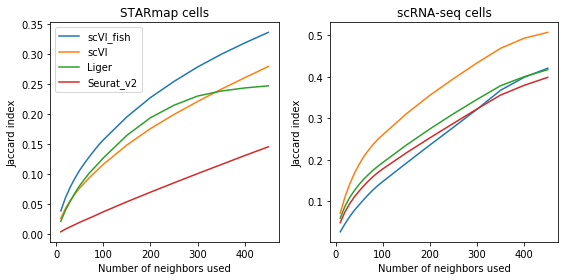

In [27]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
for method_name in purity_fish.keys():
    plt.plot(KNeighbors, purity_fish[method_name], label=method_name)
plt.xlabel("Number of neighbors used")
plt.ylabel("Jaccard index")
plt.legend()
plt.title('STARmap cells')

plt.subplot(1, 2, 2)
for method_name in purity_seq.keys():
    plt.plot(KNeighbors, purity_seq[method_name], label=method_name)
plt.xlabel("Number of neighbors used")
plt.ylabel("Jaccard index")
plt.title('scRNA-seq cells')
plt.tight_layout()

## Batch entropy: How well do the datasets mix in the latent space?

In [28]:
def get_entropy_results(methods, latents_seq, latents_fish):
    entropy = {}
    for method_name in methods:
        if method_name in ['scVI_fish', 'scVI', 'Liger', 'Seurat_v2']:
            batch_indices = np.concatenate((np.zeros(latents_seq[method_name].shape[0]), 
                                    np.ones(latents_fish[method_name].shape[0])))
            latent = np.concatenate((latents_seq[method_name],latents_fish[method_name]))
            entropy[method_name] = np.array([entropy_batch_mixing(latent, batch_indices, k) for k in KNeighbors])
        else:
            print('Unknown method name: %s' % method_name)
    return entropy

In [29]:
entropy = get_entropy_results(methods_list, dic_latent_seq, dic_latent_fish)

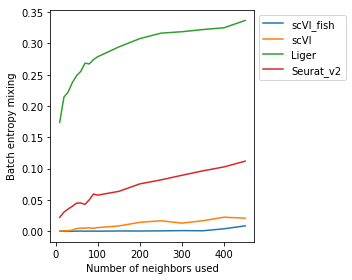

In [30]:
plt.figure(figsize=(5, 4))
plt.subplot(111)
for method_name in entropy.keys():
    plt.plot(KNeighbors, entropy[method_name], label=method_name)
plt.xlabel("Number of neighbors used")
plt.ylabel("Batch entropy mixing")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()

 ## Retrieving each method's imputed values of non observed genes

By default you will only retrieve the imputed values for the fish genes you discarded in order to gain some computation time. However, you can specify idx_genes_imputed as you wish and also feed it indexes of seq only genes whose imputed_values you are interested in.

In [31]:
def get_index(gene_names, gene, verbose=False):
    idx = None
    for gene_cortex in range(len(gene_names)):
        if gene_names[gene_cortex].lower() == gene.lower():
            idx = gene_cortex
            if verbose:
                print("Found idx " + str(idx) + " for gene " + gene + "!")
    return idx

# This list can be either just the list of genes whose value we hid during training to compute 
# imputation errors or if it can also contain scRNA seq genes not sequenced in the fish dataset (in the latter
# we won't be able to compute any imputation error or spearman correlation since the true values are not 
# observed but we can look at the maps of genes expression level in section 4)
idx_genes_imputed = idx_genes_discarded

In [32]:
def get_imputed_values(methods, latents_seq, latents_fish, genes):
    imputed_values = {}
    if len(genes) > 0:
        for method_name in methods:
            if method_name == 'scVI_fish':
                imputed_values[method_name] = trainer.get_all_latent_and_expected_frequencies(mode='smFISH')\
                ['imputed_values'][:, genes]
            elif method_name in ['scVI', 'Seurat_v2']:
                imputed = []
                for t, idx_gene1 in enumerate(genes):
                    predicted = proximity_imputation(latents_seq[method_name], gene_dataset_seq.X[:, idx_gene1], 
                                                     latents_fish[method_name], k=5)
                    imputed.append(predicted)
                imputed_values[method_name] = np.array(imputed).T
            elif method_name == 'Liger':
                imputed = []
                for t, idx_gene1 in enumerate(genes):
                    predicted = proximity_imputation(latents_seq[method_name], 
                                                     gene_dataset_seq.X[liger_cells_seq, idx_gene1], 
                                                     latents_fish[method_name], k=5)
                    imputed.append(predicted)
                imputed_values[method_name] = np.array(imputed).T
            else:
                print('Unknown method name: %s' % method_name)
    else:
        print('The list of genes to impute you gave is empty')
    return imputed_values

In [33]:
imputed_values = get_imputed_values(methods_list, dic_latent_seq, dic_latent_fish, idx_genes_imputed)

## Measuring imputation errors

In [34]:
def imputation_metrics(original, imputed):
    absolute_error = np.abs(original - imputed)
    relative_error = absolute_error / np.maximum(np.abs(original), np.ones_like(original))
    spearman = []
    for g in range(imputed.shape[1]):
        correlation = 0
        if np.mean(imputed[:, g] == 0) < 1:
            correlation = spearmanr(original[:, g], imputed[:, g])[0]
        spearman.append(correlation)
    return {"mean_absolute_error": np.mean(absolute_error, axis=1), "median_absolute_error": 
            np.median(absolute_error, axis=1), "mean_relative_error": np.mean(relative_error, axis=1), 
            "median_relative_error": np.median(relative_error, axis=1), "spearman": np.array(spearman)}

def get_imputation_results(methods, imputed, genes):
    imputation_results = {}
    for method_name in methods:
        if method_name == 'Liger':
            imputation_results[method_name] = imputation_metrics(gene_dataset_fish.X[liger_cells_fish, :]\
                                                                 [:, genes],
                                                                 imputed[method_name])
        elif method_name in ['scVI_fish', 'scVI', 'Seurat_v2']:
            imputation_results[method_name] = imputation_metrics(gene_dataset_fish.X[:, genes], 
                                                        imputed[method_name])
        else:
            print('Unknown method name: %s' % method_name)
                             
    return imputation_results

In [35]:
imputation_results = get_imputation_results(methods_list, imputed_values, idx_genes_imputed)

In [36]:
np.save('data/genes_smart', gene_dataset_fish.gene_names[idx_genes_imputed])

Outliers in the list of imputation errors happen frequently and completely skew the distribution that we fit to get a visualization of the errors, this is why we filter them 

In [37]:
def filter_outliers(data, tolerance=1.5):
    med = np.median(data)
    if med !=0:
        Q1 = np.median(data[data<med])
    else:
        Q1 = 0
    Q3 = np.median(data[data>med])
    IQR = Q3 - Q1
    return np.logical_and(data > Q1 - tolerance*IQR, data < Q3 + tolerance*IQR)

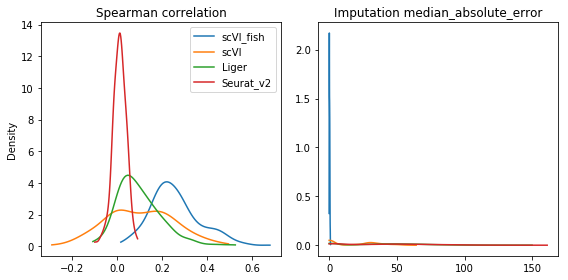

In [38]:
plt.figure(figsize=(8, 4))
error_to_plot = 'median_absolute_error'
plt.subplot(121)
for method_name in methods_list:
    spearman = imputation_results[method_name]['spearman']
    g = ~np.isnan(spearman)
    # this create the kernel, given an array it will estimate the probability over that values
    kde = gaussian_kde(spearman[g])
    # these are the values over wich your kernel will be evaluated
    dist_space = np.linspace(min(spearman[g]), max(spearman[g]), 100)
    plt.plot(dist_space, kde(dist_space), label=method_name)
plt.ylabel('Density')
plt.legend()
plt.title('Spearman correlation')

plt.subplot(122)
for method_name in methods_list:
    error = imputation_results[method_name][error_to_plot]
    filtered_data = error[filter_outliers(error, 2)]
    # this create the kernel, given an array it will estimate the probability over that values
    kde = gaussian_kde(filtered_data)
    # these are the values over wich your kernel will be evaluated
    dist_space = np.linspace(min(filtered_data), max(filtered_data), 100)
    plt.plot(dist_space, kde(dist_space), label=method_name)
plt.title('Imputation ' + error_to_plot)
plt.tight_layout()

<a id='section4'></a>

# 4. Obtaining a common meaningful representation and visualizing it

In [39]:
def get_common_umap(methods, latents_seq, latents_fish):
    umap_projection = {}
    for method_name in methods:
        if method_name in ['scVI_fish', 'scVI', 'Liger', 'Seurat_v2']:
            full_latent = np.concatenate((latents_seq[method_name], latents_fish[method_name]))
            if full_latent.shape[1] != 2:
                umap_projection[method_name] =  TSNE().fit_transform(full_latent)
        else:
            print('Unknown method name: %s' % method_name)
    return umap_projection

In [40]:
umap_dic = get_common_umap(methods_list, dic_latent_seq, dic_latent_fish)

In [41]:
method_to_plot = 'Seurat_v2'
show_umap = umap_dic[method_to_plot]
show_seq = show_umap[:dic_latent_seq[method_to_plot].shape[0]]
show_fish = show_umap[dic_latent_seq[method_to_plot].shape[0]:]

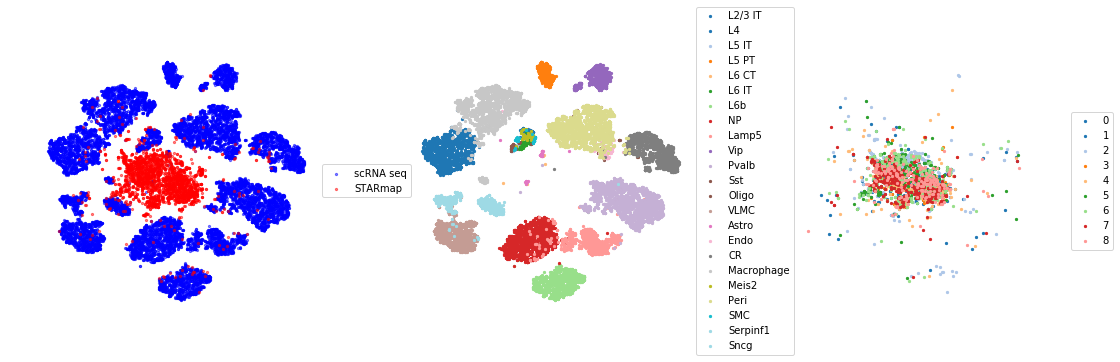

In [42]:
plt.figure(figsize=(15, 5))
ax_1 = plt.subplot(1, 3, 1)
plt.axis("off")
ax_1.scatter(show_seq[:, 0], show_seq[:, 1], c='b', alpha=0.5, label='scRNA seq', s=5)
ax_1.scatter(show_fish[:, 0], show_fish[:, 1], c='r', alpha=0.5, label='STARmap', s=5)
box_1 = ax_1.get_position()
ax_1.set_position([box_1.x0, box_1.y0, box_1.width * 0.8, box_1.height])
# Put a legend to the right of the current axis
ax_1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
lim_x = plt.xlim()
lim_y = plt.ylim()
ax_2 = plt.subplot(1, 3, 2)
plt.axis("off")
colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(gene_dataset_seq.cell_types)))
for i, c in zip(np.unique(gene_dataset_seq.labels.ravel()), colors):
    ax_2.scatter(show_seq[gene_dataset_seq.labels.ravel() == i, 0], 
                show_seq[gene_dataset_seq.labels.ravel() == i, 1], color=c, 
               label=gene_dataset_seq.cell_types[i], s=5)
box_2 = ax_2.get_position()
ax_2.set_position([box_2.x0, box_2.y0, box_2.width * 0.8, box_2.height])
# Put a legend to the right of the current axis
ax_2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(lim_x)
plt.ylim(lim_y)

ax_3 = plt.subplot(1, 3, 3)
plt.axis("off")
for i, c in zip(np.unique(gene_dataset_fish.labels.ravel()), colors):
    ax_3.scatter(show_fish[gene_dataset_fish.labels.ravel() == i, 0], 
                show_fish[gene_dataset_fish.labels.ravel() == i, 1], color=c, 
               label=gene_dataset_fish.cell_types[i], s=5)
box_3 = ax_3.get_position()
ax_3.set_position([box_3.x0, box_3.y0, box_3.width * 0.8, box_3.height])
# Put a legend to the right of the current axis
ax_3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(lim_x)
plt.ylim(lim_y)
plt.tight_layout()
plt.savefig('Results/SMARTseq4_starmap1000/latent_embedding_tsne_%s.pdf' % method_to_plot)

I used the code available on STARmap's github repo to cluster the STARmap1000 dataset but the labels don't have names yet

<a id='section5'></a>

# 5. Classifying the fish cells using their latent representation

In [43]:
def predict_labels(latent_seq, latent_fish, labels_dataset_seq):
    classifier = neighbors.KNeighborsClassifier(5, weights='distance')
    classifier.fit(latent_seq, labels_dataset_seq)
    inferred_labels = classifier.predict(latent_fish)
    return inferred_labels

def get_all_inferred_labels(methods, latents_seq, latents_fish, labels_seq, labels_fish):
    cluster_names = {}
    for method_name in methods:
        if method_name in ['scVI_fish', 'scVI', 'Seurat_v2']:
            labels_seq[method_name] = gene_dataset_seq.labels.ravel()
            labels_fish[method_name] = predict_labels(latents_seq[method_name], latents_fish[method_name], 
                                                      labels_seq[method_name])
            cluster_names[method_name] = gene_dataset_seq.cell_types
        elif method_name == 'Liger':
            # The labels found by liger were already retrieved when the liger analysis was run
            labels = np.concatenate((labels_seq[method_name], labels_fish[method_name]))
            n_labels = len(np.unique(labels))
            names = []
            for i in range(n_labels):
                cells = np.where(labels_seq[method_name] == i)[0]
                # naming the clusters inferred by Liger with the label of the cluster provided with the dataset
                # that is present in majority in the Liger cluster
                names.append(gene_dataset_seq.cell_types[np.unique(gene_dataset_seq.labels[cells])
                                                         [np.argmax(np.unique(gene_dataset_seq.labels[cells], 
                                                                             return_counts=True)[1])]])
            # we reorder the labels inferred by Liger so that layers of the cortex appear in the right order 
            # when we plot the labels on maps of the tissues
            order = []
            for cluster in names:
                order.append(np.where(gene_dataset_seq.cell_types == cluster)[0][0])
            new_order = np.argsort(order)
            new_names = [names[i] for i in new_order]
            new_labels = np.vectorize(lambda x: np.where(new_order == x)[0][0])(labels)
            labels_seq[method_name] = new_labels[:len(labels_seq[method_name])]
            labels_fish[method_name] = new_labels[len(labels_seq[method_name]):]
            cluster_names[method_name] = np.array(new_names)
        else:
            print('Unknown method name: %s' % method_name)
    return labels_seq, labels_fish, cluster_names

In [44]:
labels_seq_dic, labels_fish_dic, dic_cluster_names = get_all_inferred_labels(methods_list, dic_latent_seq, 
                                                                             dic_latent_fish, 
                                                  labels_seq_dic, labels_fish_dic)

The following list gives a way to reorder the smart seq labels so that we can see the different layers of the cortex in the right order like in the Seuratv3 preprint paper

In [52]:
method_to_plot = 'Liger'
labels_to_plot = labels_fish_dic[method_to_plot]
n_labels = len(np.unique(labels_to_plot))

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


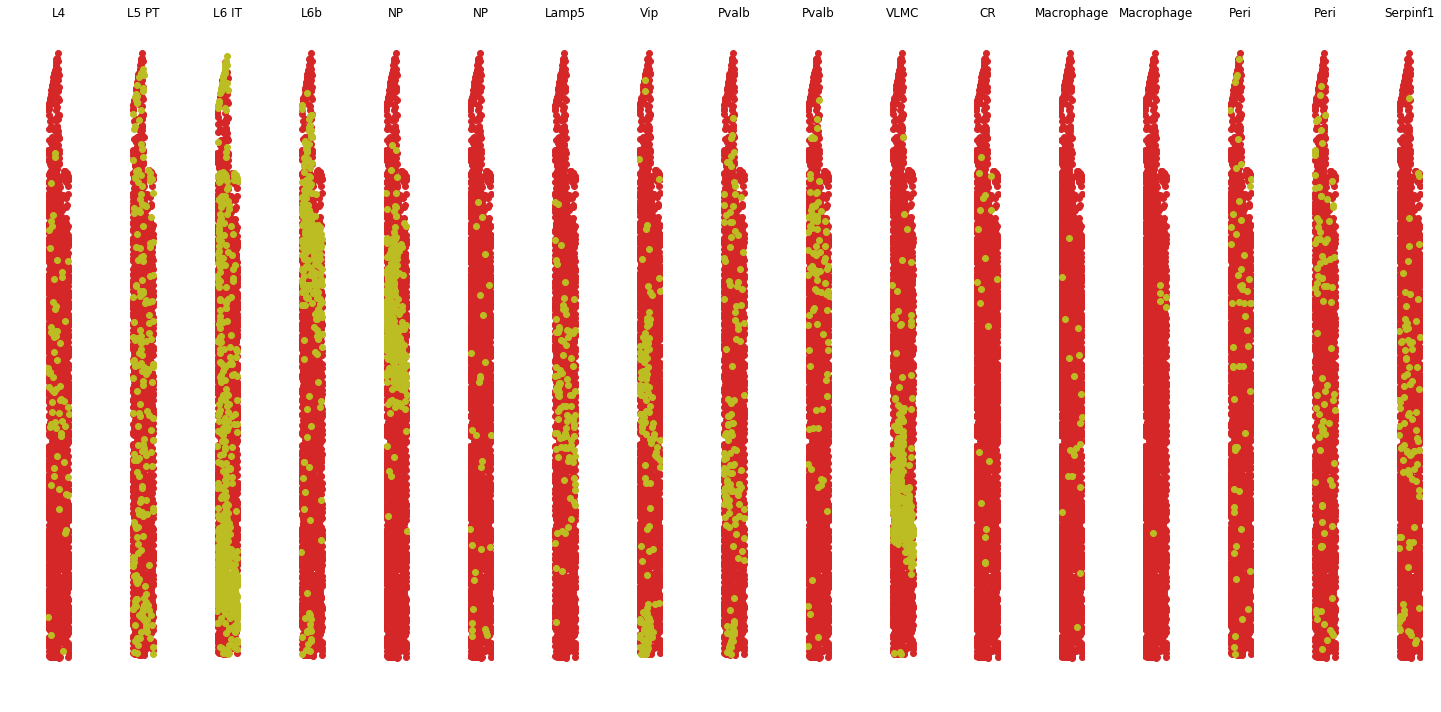

In [53]:
x = gene_dataset_fish.x_coord
y = gene_dataset_fish.y_coord
if method_to_plot == 'Liger':
    x = x[liger_cells_fish]
    y = y[liger_cells_fish]
colors = plt.cm.get_cmap('tab20')(np.array([0.3, 0.8]))
plt.figure(figsize=(20, 10))
plt.subplot(1,n_labels,1)
for i, k in zip(np.unique(labels_to_plot), np.arange(n_labels)):
    plt.subplot(1,n_labels,k + 1)
    plt.axis('off')
    cells = (labels_to_plot == i)
    label_plotted = np.zeros_like(labels_to_plot)
    label_plotted[cells] = np.ones_like(labels_to_plot)[cells]
    plt.scatter(x[~cells], y[~cells], c=colors[0])
    plt.scatter(x[cells], y[cells], c=colors[1])
    plt.title(dic_cluster_names[method_to_plot][i])
plt.tight_layout()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


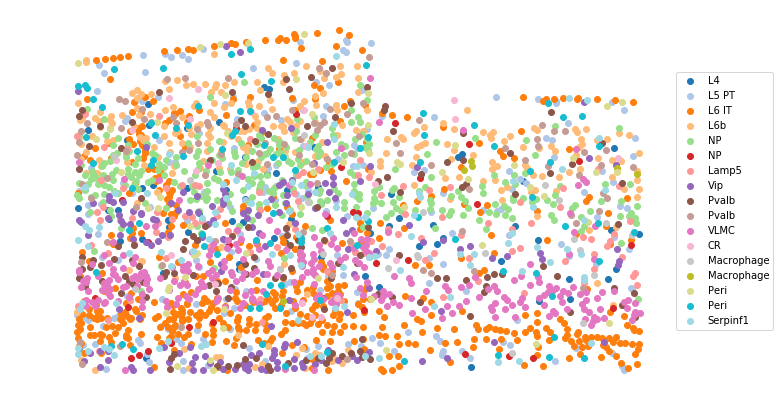

In [54]:
plt.figure(figsize=(14, 7))
plt.axis("off")
colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, n_labels))
ax = plt.subplot(111)
for i, c in zip(np.unique(labels_to_plot), colors):
    ax.scatter(x[labels_to_plot == i], 
                y[labels_to_plot == i], color=c, 
               label=dic_cluster_names[method_to_plot][i])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

<a id='section6'></a>

# 6. Finding spatially DE genes

## Visualizing the map of gene expression levels

In [55]:
# give index of the gene in genes_fish you're interested in
# you can use the method get_index if you know that gene's name but not its index
gene_of_interest = 30
method_to_plot = 'scVI_fish'
if gene_of_interest in idx_genes_imputed:
    idx_in_imputed = np.where(idx_genes_imputed==gene_of_interest)[0][0]
else:
    print("You did not retrieve the imputed values for this gene when you specified the list idx_genes_imputed \n \
You can go back to where the get_imputed_values() method is called and add your gene to idx_genes_imputed")

In [56]:
x = gene_dataset_fish.x_coord.ravel()
y = gene_dataset_fish.y_coord.ravel()
if method_to_plot == 'Liger':
    x = x[liger_cells_fish]
    y = y[liger_cells_fish]
    true_log_counts = np.log(1 + gene_dataset_fish.X[liger_cells_fish][:, gene_of_interest])
else:
    true_log_counts = np.log(1 + gene_dataset_fish.X[:, gene_of_interest])
method = np.log(1 + imputed_values[method_to_plot][:, idx_in_imputed])
# We filter outlier values otherwise these values skew the colormap and we can't see any
# differential expression
cells = filter_outliers(method, tolerance=1.5)
cells_bis = filter_outliers(true_log_counts, tolerance=1.5)

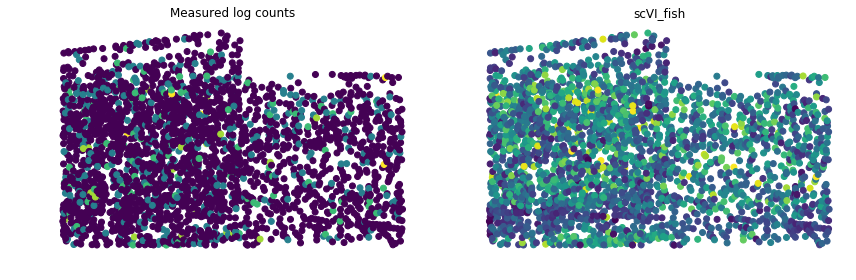

In [57]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(x[cells_bis], y[cells_bis], c=true_log_counts[cells_bis])
plt.title("Measured log counts")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.scatter(x[cells], y[cells], c=method[cells])
plt.title(method_to_plot)
plt.axis("off")
plt.tight_layout()

## Visualing spatial maps of genes measured only in the scRNA seq experiment

In [ ]:
# give index of the gene in gene_dataset_seq.gene_names you're interested in
# you can use the method get_index if you know that gene's name but not its index
gene_of_interest = 
method_to_plot = 'scVI_fish'
if gene_of_interest in idx_genes_imputed:
    idx_in_imputed = np.where(idx_genes_imputed==gene_of_interest)[0][0]
else:
    print("You did not retrieve the imputed values for this gene when you specified the list idx_genes_imputed \n \
You can go back to where the get_imputed_values() method is called and add your gene to idx_genes_imputed")

In [ ]:
x = gene_dataset_fish.x_coord.ravel()
y = gene_dataset_fish.y_coord.ravel()
if method_to_plot == 'Liger':
    x = x[liger_cells_fish]
    y = y[liger_cells_fish]
method = np.log(1 + imputed_values[method_to_plot][:, idx_in_imputed])
# We filter outlier values otherwise these values skew the colormap and we can't see any
# differential expression
cells = filter_outliers(method, tolerance=1.5)
cells_bis = filter_outliers(true_log_counts, tolerance=1.5)

In [ ]:
plt.figure(figsize=(6, 4))
plt.subplot(1, 1, 1)
plt.scatter(x[cells], y[cells], c=method[cells])
plt.title(method_to_plot)
plt.axis("off")
plt.tight_layout()

## Calculating spatial differential expression metrics: work in progress

In [22]:
positions = np.concatenate((gene_dataset_starmap.x_coord[:, np.newaxis], gene_dataset_starmap.y_coord[:, np.newaxis]), 
                           axis=1)
print(positions.shape)

(2522, 2)


In [23]:
w = distance_matrix(positions, positions)
mi = pysal.Moran(gene_dataset_starmap.X[:, gene_of_interest].ravel(), w)
print(mi.I)

AttributeError: 'numpy.ndarray' object has no attribute 'transform'

In [56]:
def allow_notebook_for_test():
    print("Testing the scRNA and starMAP notebook")
    
# don't mind this, it is used only when the travis build tests the notebooks